<a href="https://colab.research.google.com/github/findQin/ColabCode/blob/master/mynlpLearn3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf

In [ ]:
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# 用于分词器Tokenizer，词汇表大小，词汇表保存的词的数量，基于词频
vocab_size = 10000

# 生成的词向量维度
embedding_dim = 16

# 训练数据与测试数据中句子长度的控制
max_length = 100

# 因为要控制句子长度，超过 max_length 的就要截断，这里是从后方截断
trunc_type = 'post'

# 因为要控制句子长度，不够 max_length 的就要填充，从后方填充
padding_type = 'post'

# Tokenizer 分词器拟合训练数据，保存了出现频率最高前 vocab_size 个词，
# 在将词转换为整数编码时，对于那些未出现词汇表中的词，转换不了对应的整数编码，
# 便用 oov_tok 来代替
oov_tok = "<OOV>"

# 训练集长度
training_size = 25000

# 分类类别
num_classes=2         

&nbsp;  

In [ ]:
import pandas as pd

df = pd.read_csv('drive/My Drive/myDataSets/imdb.csv')

In [ ]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df['review'][:3]

0    One of the other reviewers has mentioned that ...
1    A wonderful little production. <br /><br />The...
2    I thought this was a wonderful way to spend ti...
Name: review, dtype: object

&nbsp;  

In [ ]:
sentences = df['review'].values

In [ ]:
len(sentences)

50000

In [ ]:
type(sentences)

numpy.ndarray

In [ ]:
sentences[:2]

array(["One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to

&nbsp;  

In [ ]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]

In [ ]:
len(training_sentences)

25000

 &nbsp;  

In [ ]:
'positive' == df['sentiment'][0]

True

In [ ]:
len(df)

50000

In [ ]:
labels = []

for i in range(len(df)):
  if df['sentiment'][i] == 'positive':
    labels.append(1)
  else:
    labels.append(0)

In [ ]:
labels[:10]

[1, 1, 1, 0, 1, 1, 1, 0, 0, 1]

In [ ]:
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

 &nbsp;  

分词器拟合训练集中的评论

In [ ]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

得到词汇表  {' OOV ' : 1,  '  to ' : 2, ...}

In [ ]:
word_index = tokenizer.word_index

将训练集中的评论文本转为整数编码，然后将这些句子的整数编码通过填充、截断使其长度一致为 max_length

In [ ]:
training_sequences = tokenizer.texts_to_sequences(training_sentences)

training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

测试集评论文本也是同样操作

In [ ]:
testing_sequences = tokenizer.texts_to_sequences(testing_sentences)

testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

数据转换成 tensorflow 支持的格式

In [ ]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np

training_padded = np.array(training_padded)
training_labels = np.array(training_labels)

testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

Conv1D 中 padding='VALID'
[参考这篇博客](https://blog.csdn.net/wuzqChom/article/details/74785643)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(filters=256, kernel_size=2, kernel_initializer='he_normal', strides=1, padding='VALID', activation='relu', name='conv'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(rate=0.5, name='dropout'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 16)           160000    
_________________________________________________________________
conv (Conv1D)                (None, 99, 256)           8448      
_________________________________________________________________
global_average_pooling1d_2 ( (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 168,962
Trainable params: 168,962
Non-trainable params: 0
_________________________________________________________________


In [ ]:
num_epochs = 30

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_split=0.1, verbose=2)

Epoch 1/30
704/704 - 4s - loss: 0.4984 - accuracy: 0.7430 - val_loss: 0.3983 - val_accuracy: 0.8244
Epoch 2/30
704/704 - 4s - loss: 0.3237 - accuracy: 0.8635 - val_loss: 0.3863 - val_accuracy: 0.8324
Epoch 3/30
704/704 - 4s - loss: 0.2721 - accuracy: 0.8884 - val_loss: 0.4069 - val_accuracy: 0.8224
Epoch 4/30
704/704 - 3s - loss: 0.2363 - accuracy: 0.9052 - val_loss: 0.4356 - val_accuracy: 0.8168
Epoch 5/30
704/704 - 3s - loss: 0.2081 - accuracy: 0.9180 - val_loss: 0.4870 - val_accuracy: 0.8136
Epoch 6/30
704/704 - 4s - loss: 0.1888 - accuracy: 0.9252 - val_loss: 0.5258 - val_accuracy: 0.8052
Epoch 7/30
704/704 - 3s - loss: 0.1701 - accuracy: 0.9345 - val_loss: 0.5730 - val_accuracy: 0.8060
Epoch 8/30
704/704 - 3s - loss: 0.1543 - accuracy: 0.9418 - val_loss: 0.6354 - val_accuracy: 0.7976
Epoch 9/30
704/704 - 4s - loss: 0.1417 - accuracy: 0.9454 - val_loss: 0.6955 - val_accuracy: 0.7928
Epoch 10/30
704/704 - 3s - loss: 0.1296 - accuracy: 0.9507 - val_loss: 0.7530 - val_accuracy: 0.7944

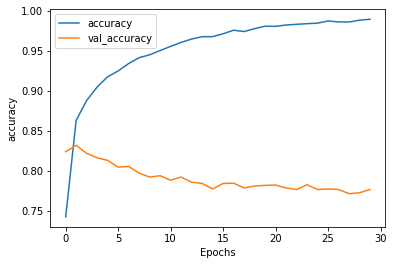

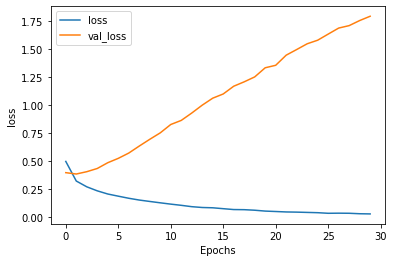

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [ ]:
result = model.evaluate(testing_padded, testing_labels)


782/782 [==============================] - 2s 2ms/step - loss: 1.6995 - accuracy: 0.7843


In [ ]:
print("Accuracy: {0:.2%}".format(result[1]))


Accuracy: 78.43%


&nbsp;  

反转词汇表看看 {1 : '&lt;OOV>', &nbsp;&nbsp;2 : 'to', ...}

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

In [ ]:
reverse_word_index[1]

'<OOV>'

In [ ]:
def decode_sentence(text):
  # get(i, '?') 指定的键值不存在时，用？代替
  return ' '.join([reverse_word_index.get(i, '?') for i in text])

decode_sentence(training_padded[0])

"one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked they are right as this is exactly what happened with me br br the first thing that struck me about oz was its brutality and <OOV> scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or <OOV> this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the word br br it is called oz as that is the <OOV>"

In [ ]:
len(training_padded[0])

100